# Trabajo Práctico - Clasificación de Incidentes de Ciberseguridad

1- Diseño del modelo
- Diseñar una red neuronal MLP utilizando una librería de aprendizaje profundo (por ejemplo, TensorFlow/Keras o PyTorch).
- Justificar las decisiones de diseño: número de capas ocultas, cantidad de neuronas por capa, funciones de activación, etc.
- Utilizar los mismos conjuntos de entrenamiento y validación generados en CD para entrenar y evaluar el modelo.


1.1- Importar librerias necesarias


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import display
from itertools import product
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (classification_report,
                             confusion_matrix, roc_auc_score,
                             roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)

import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import random

1.2  - Cargar el dataset


In [2]:
df = pd.read_csv('df_preprocesado.csv')
X  = df.drop('attack', axis=1)               # 17 columnas  sin variable objetivo
y  = df['attack']                            # variable objetivo (0/1)

In [3]:
# Mostrar los datos almacenados en las variables X e Y

# print("Datos de X:")
display(X)

# print("Datos de Y:")
display(y)

,protocol_ICMP,protocol_TCP,protocol_UDP,browser_type_Chrome,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown,login_attempts,duration,packet_size,encryption_used_AES,encryption_used_DES,encryption_used_Unknown,ip_reputation_score,failed_logins,unusual_time_access
0,0,1,0,0,1,0,0,0,0.250000,0.068497,0.438165,0,1,0,0.655587,0.2,0.0
1,0,1,0,0,0,1,0,0,0.166667,0.216623,0.334152,0,1,0,0.324443,0.0,0.0
2,0,1,0,1,0,0,0,0,0.166667,0.010368,0.462735,0,1,0,0.799160,0.4,0.0
3,0,0,1,0,0,0,0,1,0.250000,0.083555,0.606061,0,1,0,0.131015,0.0,0.0
4,0,1,0,0,0,1,0,0,0.333333,0.073998,0.318591,1,0,0,0.056820,0.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9532,1,0,0,1,0,0,0,0,0.166667,0.031370,0.106470,1,0,0,0.558949,0.6,0.0
9533,0,1,0,1,0,0,0,0,0.166667,0.025362,0.258804,0,0,1,0.440429,0.0,0.0
9534,0,1,0,0,0,1,0,0,0.333333,0.004822,0.491400,1,0,0,0.386963,0.2,0.0
9535,0,1,0,1,0,0,0,0,0.250000,0.011984,0.280098,1,0,0,0.580298,0.2,1.0


,attack
0,1
1,0
2,1
3,1
4,0
...,...
9532,1
9533,0
9534,0
9535,0


1.3 - División del modelo en entrenamiento y validación

In [4]:
# 80 % entrenamiento - 20 % validación, estratificando para preservar la proporción de clases
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

 1.4  Definición de la arquitectura MLP

 Justificación de hiper-parámetros:
   - Dos capas ocultas (64-32) → suficiente capacidad sin sobre-ajustar un dataset mediano
   - ReLU → activación por defecto para capas ocultas (evita saturación, entrenamiento estable)
   - Dropout 0.30 y 0.20 → regularización contra overfitting
   - Capa de salida sigmoide → predicción binaria (ataque / no ataque)

In [5]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.30),
    Dense(32, activation='relu'),
    Dropout(0.20),
    Dense(1, activation='sigmoid')          # salida binaria
])

1.5  Compilación del modelo
  - Optimizador Adam → buen punto de partida para la mayoría de problemas.
  - Pérdida binary_crossentropy → adecuada para clasificación binaria.
  - Métrica accuracy para seguimiento rápido (luego añadiremos otras métricas en Ítem 3).

In [6]:


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Ver resumen de la red
model.summary()

# 1.6  Entrenamiento inicial (smoke test)
# EarlyStopping detiene cuando la validación deja de mejorar 5 epochs seguidas.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,           # aumentá si no se activa EarlyStopping antes
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5589 - loss: 0.6844 - val_accuracy: 0.7102 - val_loss: 0.6144
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6870 - loss: 0.6011 - val_accuracy: 0.7290 - val_loss: 0.5549
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7283 - loss: 0.5514 - val_accuracy: 0.7285 - val_loss: 0.5423
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7399 - loss: 0.5328 - val_accuracy: 0.7348 - val_loss: 0.5311
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7424 - loss: 0.5231 - val_accuracy: 0.7432 - val_loss: 0.5208
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7545 - loss: 0.5124 - val_accuracy: 0.7579 - val_loss: 0.5042
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7725 - loss: 0.4897 - val_accuracy: 0.7804 - val_loss: 0.4814
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7881 - loss: 0.4640 - val_accuracy: 0.

# 2. Ajuste de hiperparámetros
- Explorar diferentes combinaciones de hiperparámetros: tasa de aprendizaje, tamaño del batch, número de épocas,función de pérdida, optimizador, regularización (dropout, L2, etc.).
- Documentar cómo estos cambios afectan la performance del modelo.

In [7]:
# 2.1  Definimos la función que construye el modelo
#       (recibe los hiperparámetros como argumentos)
# ------------------------------------------------------------------
def build_model(input_dim, lr=1e-3, n1=64, n2=32, drop1=0.3, drop2=0.2,
                opt_name="adam", l2_reg=0.0):
    model = Sequential([
        Dense(n1, activation="relu",
              kernel_regularizer=l2(l2_reg),
              input_shape=(input_dim,)),
        Dropout(drop1),
        Dense(n2, activation="relu",
              kernel_regularizer=l2(l2_reg)),
        Dropout(drop2),
        Dense(1, activation="sigmoid")
    ])

    if opt_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif opt_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    elif opt_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    else:
        raise ValueError(f"Optimizador no soportado: {opt_name}")

    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# ------------------------------------------------------------------
# 2.2  Espacio de búsqueda
# ------------------------------------------------------------------
param_grid = {
    "lr"       : [1e-2, 5e-3, 1e-3],
    "batch"    : [16, 32, 64],
    "opt"      : ["adam", "rmsprop"],
    "n1"       : [64, 128],
    "n2"       : [32, 64],
    "drop1"    : [0.2, 0.3],
    "drop2"    : [0.1, 0.2],
    "l2_reg"   : [0.0, 1e-4],
    "epochs"   : [50],          # EarlyStopping corta antes si conviene
}

# Generamos todas las combinaciones (o una muestra aleatoria si hay muchas)
all_combinations = list(product(
    param_grid["lr"], param_grid["batch"], param_grid["opt"],
    param_grid["n1"], param_grid["n2"], param_grid["drop1"],
    param_grid["drop2"], param_grid["l2_reg"], param_grid["epochs"]
))

# Para demo rápida, nos quedamos con un máximo de 20 combinaciones
np.random.seed(42)

# if len(all_combinations) > 20:
#     all_combinations = list(np.random.choice(all_combinations, 20, replace=False))   Esto no funciono porque no es un array unidimensional
if len(all_combinations) > 20:
    all_combinations = random.sample(all_combinations, 20)
results = []

# ------------------------------------------------------------------
# 2.3  Bucle de entrenamiento y evaluación
# ------------------------------------------------------------------
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

for (lr, bs, opt, n1, n2, d1, d2, l2reg, n_epochs) in all_combinations:
    print(f"Entrenando: lr={lr}, bs={bs}, opt={opt}, n1={n1}, n2={n2}, "
          f"drop=({d1},{d2}), l2={l2reg}")

    model = build_model(
        input_dim=X_train.shape[1],
        lr=lr, n1=n1, n2=n2,
        drop1=d1, drop2=d2,
        opt_name=opt, l2_reg=l2reg
    )

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=n_epochs,
        batch_size=bs,
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluación sobre el validation hold-out
    y_prob = model.predict(X_val).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    acc  = accuracy_score (y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec  = recall_score   (y_val, y_pred)
    f1   = f1_score       (y_val, y_pred)

    results.append({
        "lr"     : lr,
        "batch"  : bs,
        "opt"    : opt,
        "n1"     : n1,
        "n2"     : n2,
        "drop1"  : d1,
        "drop2"  : d2,
        "l2_reg" : l2reg,
        "epochs" : len(history.history["loss"]),
        "val_acc": acc,
        "val_f1" : f1,
        "prec"   : prec,
        "rec"    : rec
    })

# ------------------------------------------------------------------
# 2.4  Resultados ordenados
# ------------------------------------------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("val_f1", ascending=False).reset_index(drop=True)
display(results_df.head(10))         # top-10 combinaciones

# Guardamos para análisis posterior
results_df.to_csv("hp_results_mlp.csv", index=False)

Entrenando: lr=0.005, bs=64, opt=adam, n1=64, n2=64, drop=(0.3,0.1), l2=0.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Entrenando: lr=0.005, bs=32, opt=rmsprop, n1=64, n2=64, drop=(0.2,0.2), l2=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Entrenando: lr=0.01, bs=32, opt=adam, n1=128, n2=32, drop=(0.3,0.1), l2=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Entrenando: lr=0.001, bs=16, opt=adam, n1=64, n2=64, drop=(0.3,0.2), l2=0.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Entrenando: lr=0.001, bs=16, opt=adam, n1=128, n2=64, drop=(0.2,0.2), l2=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Entrenando: lr=0.005, bs=64, opt=adam, n1=64, n2=64, drop=(0.3,0.2), l2=0.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Entrenando: lr=0.01, bs=32, opt=rmsprop, n1=64, n2=64, drop=(0.3,0.2), l2=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Entrenando: lr=0.01, bs=64, opt=adam, n1=128, n2=32, drop=(0.2,0.2), l2=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Entrenando: lr=0.005, bs=32, opt=rmsprop, n1=64, n2=64, drop=(0.3,0.1), l2=0.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Entrenando: lr=0.01, bs=32, opt=rmsprop, n1=64, n2=32, drop=(0.3,0.1), l2=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Entrenando: lr=0.005, bs=16, opt=adam, n1=64, n2=64, drop=(0.2,0.2), l2=0.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Entrenando: lr=0.005, bs=32, opt=adam, n1=64, n2=64, drop=(0.3,0.1), l2=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Entrenando: lr=0.01, bs=16, opt=adam, n1=64, n2=64, drop=(0.3,0.2), l2=0.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Entrenando: lr=0.01, bs=32, opt=rmsprop, n1=64, n2=32, drop=(0.2,0.1), l2=0.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Entrenando: lr=0.001, bs=64, opt=rmsprop, n1=128, n2=64, drop=(0.2,0.2), l2=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Entrenando: lr=0.005, bs=32, opt=adam, n1=128, n2=32, drop=(0.2,0.2), l2=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Entrenando: lr=0.005, bs=32, opt=rmsprop, n1=64, n2=64, drop=(0.3,0.1), l2=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Entrenando: lr=0.01, bs=64, opt=adam, n1=128, n2=32, drop=(0.3,0.1), l2=0.0001


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Entrenando: lr=0.01, bs=64, opt=adam, n1=128, n2=32, drop=(0.3,0.2), l2=0.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Entrenando: lr=0.005, bs=16, opt=adam, n1=64, n2=64, drop=(0.3,0.1), l2=0.0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,lr,batch,opt,n1,n2,drop1,drop2,l2_reg,epochs,val_acc,val_f1,prec,rec
0,0.005,16,adam,64,64,0.3,0.1,0.0000,24,0.882075,0.849095,0.992163,0.742087
1,0.005,32,adam,128,32,0.2,0.2,0.0001,33,0.879455,0.845638,0.989011,0.738570
2,0.005,32,adam,64,64,0.3,0.1,0.0001,31,0.878407,0.845539,0.978428,0.744431
3,0.010,32,adam,128,32,0.3,0.1,0.0001,15,0.878407,0.844712,0.984399,0.739742
4,0.001,64,rmsprop,128,64,0.2,0.2,0.0001,45,0.878407,0.844504,0.985915,0.738570
5,0.010,32,rmsprop,64,64,0.3,0.2,0.0001,24,0.878407,0.844504,0.985915,0.738570
6,0.001,16,adam,128,64,0.2,0.2,0.0001,33,0.877358,0.843373,0.982839,0.738570
7,0.010,64,adam,128,32,0.3,0.2,0.0000,26,0.877358,0.841463,0.996790,0.728019
8,0.001,16,adam,64,64,0.3,0.2,0.0000,29,0.874214,0.841060,0.966514,0.744431
9,0.010,64,adam,128,32,0.3,0.1,0.0001,22,0.876834,0.840678,0.996785,0.726846


#3. Evaluación del modelo
- Proponer y calcular métricas apropiadas para evaluar el modelo (por ejemplo: accuracy, precision, recall, F1-score, AUC-ROC).
- Graficar y analizar las curvas de aprendizaje (loss y accuracy) para entrenamiento y validación.

Hiperparámetros seleccionados:
 lr            0.005
batch            16
opt            adam
n1               64
n2               64
drop1           0.3
drop2           0.1
l2_reg          0.0
epochs           24
val_acc    0.882075
val_f1     0.849095
prec       0.992163
rec        0.742087
Name: 0, dtype: object
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


382/382 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6344 - loss: 0.6310 - val_accuracy: 0.7398 - val_loss: 0.5329
Epoch 2/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7587 - loss: 0.5177 - val_accuracy: 0.8028 - val_loss: 0.4484
Epoch 3/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7974 - loss: 0.4406 - val_accuracy: 0.8283 - val_loss: 0.3922
Epoch 4/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8232 - loss: 0.4014 - val_accuracy: 0.8617 - val_loss: 0.3687
Epoch 5/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8357 - loss: 0.3845 - val_accuracy: 0.8663 - val_loss: 0.3513
Epoch 6/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8545 - loss: 0.3581 - val_accuracy: 0.8637 - val_loss: 0.3447
Epoch 7/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8570 - loss: 0.3547 - val_accuracy: 0.8578 - val_loss: 0.3560
Epoch 8/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8650 - loss: 0.3419 - val_accuracy: 0.8657

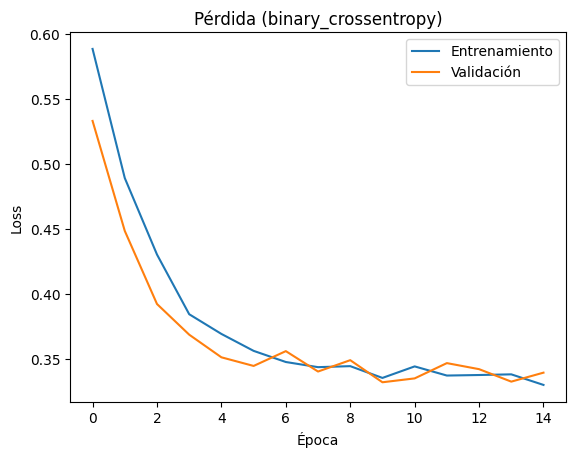

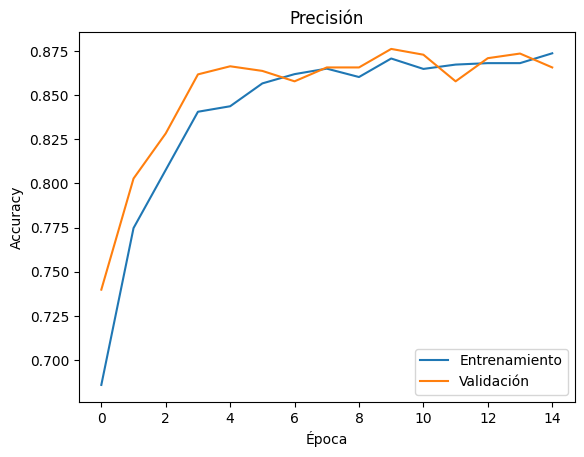

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0     0.8262    0.9867    0.8994      1055
           1     0.9784    0.7433    0.8448       853

    accuracy                         0.8779      1908
   macro avg     0.9023    0.8650    0.8721      1908
weighted avg     0.8942    0.8779    0.8750      1908

Accuracy : 0.8779
Precision: 0.9784
Recall   : 0.7433
F1-score : 0.8448
AUC-ROC  : 0.8748


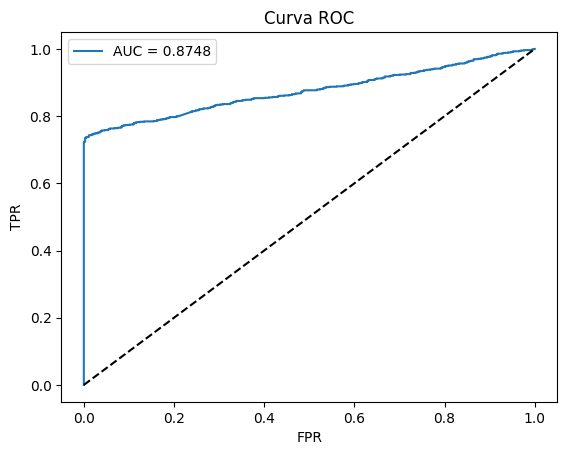

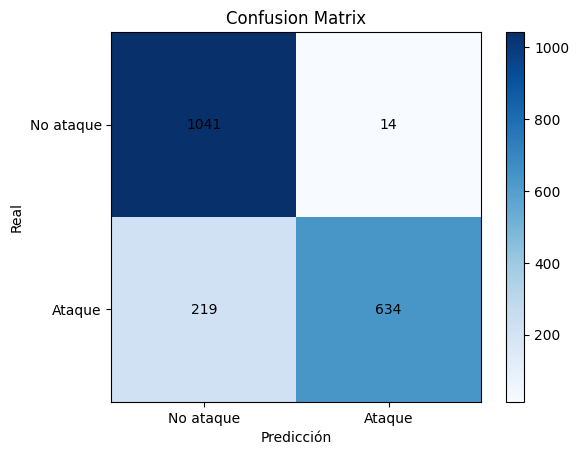

In [8]:
# 3.1  Elegir mejores hiperparámetros
#       • Opción A: cargar top-1 de hp_results_mlp.csv
# ---------------------------------------------------------
TOP_RESULTS_FILE = "hp_results_mlp.csv"       # generado en el Ítem 2
hp_df = pd.read_csv(TOP_RESULTS_FILE).sort_values("val_f1", ascending=False)
best = hp_df.iloc[0]                           # top-1 combinación

#  Si deseamos fijarlos a mano, comentar las dos líneas anteriores
# y rellena los valores aquí:
# best = {
#     "lr"     : 0.001,
#     "batch"  : 32,
#     "opt"    : "adam",
#     "n1"     : 128,
#     "n2"     : 64,
#     "drop1"  : 0.3,
#     "drop2"  : 0.2,
#     "l2_reg" : 0.0,
# }

print("Hiperparámetros seleccionados:\n", best)

# ---------------------------------------------------------
# 3.2  Carga y partición del dataset
# ---------------------------------------------------------
df = pd.read_csv("df_preprocesado.csv")
X  = df.drop("attack", axis=1)
y  = df["attack"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ---------------------------------------------------------
# 3.3  Construcción del modelo definitivo
# ---------------------------------------------------------
def build_model(input_dim, hp):
    model = Sequential([
        Dense(int(hp["n1"]), activation="relu",
              kernel_regularizer=l2(hp["l2_reg"]),
              input_shape=(input_dim,)),
        Dropout(hp["drop1"]),
        Dense(int(hp["n2"]), activation="relu",
              kernel_regularizer=l2(hp["l2_reg"])),
        Dropout(hp["drop2"]),
        Dense(1, activation="sigmoid")
    ])

    if hp["opt"] == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=hp["lr"])
    elif hp["opt"] == "rmsprop":
        opt = tf.keras.optimizers.RMSprop(learning_rate=hp["lr"])
    else:                                 # SGD como respaldo
        opt = tf.keras.optimizers.SGD(learning_rate=hp["lr"],
                                      momentum=0.9)

    model.compile(optimizer=opt,
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

model = build_model(X_train.shape[1], best)

# ---------------------------------------------------------
# 3.4  Entrenamiento con Early-Stopping
# ---------------------------------------------------------
early_stop = EarlyStopping(monitor="val_loss",
                           patience=5,
                           restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=int(best["batch"]),
    callbacks=[early_stop],
    verbose=1
)

# ---------------------------------------------------------
# 3.5  Curvas de aprendizaje (loss & accuracy)
# ---------------------------------------------------------
plt.figure()
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.title("Pérdida (binary_crossentropy)")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="Entrenamiento")
plt.plot(history.history["val_accuracy"], label="Validación")
plt.title("Precisión")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# ---------------------------------------------------------
# 3.6  Métricas finales en test-set
# ---------------------------------------------------------
y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))

acc  = accuracy_score (y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score   (y_test, y_pred)
f1   = f1_score       (y_test, y_pred)
auc  = roc_auc_score  (y_test, y_prob)

print(f"Accuracy : {acc :.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec :.4f}")
print(f"F1-score : {f1 :.4f}")
print(f"AUC-ROC  : {auc:.4f}")

# ---------------------------------------------------------
# 3.7  Curva ROC
# ---------------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend()
plt.show()

# ---------------------------------------------------------
# 3.8  Matriz de confusión
# ---------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No ataque", "Ataque"])
plt.yticks(tick_marks, ["No ataque", "Ataque"])
plt.xlabel("Predicción")
plt.ylabel("Real")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.show()

#Juicio global
##Fortalezas

Convergencia estable y sin sobre-entrenamiento.

Muy alta precision para los incidentes: los analistas casi nunca revisarán falsos avisos.

AUC respetable  → buena capacidad discriminatoria.

##Debilidades

Recall de ataques podría ser insuficiente en entornos donde el coste de un falso negativo es alto.

Ligera asimetría entre clases: el modelo está “sesgado” a evitar falsas alarmas más que a capturar todos los ataques.

##Recomendaciones

Ajustar el umbral de decisión (p. ej. 0,40 en lugar de 0,50) para subir el recall manteniendo precision aceptable, guiándose por la curva ROC.

Ponderar la clase minoritaria o aplicar focal loss para penalizar más los FN.

Explorar arquitecturas que capturen mejor patrones raros (p. ej. ensemble de MLP + Gradient Boosting, o redes recurrentes si hay secuencias).

En síntesis, la MLP entrega un rendimiento bueno y consistente para un trabajo práctico, demostrando ventajas sobre métodos lineales; sin embargo, aún requiere ajustes finos para maximizar la detección de ataques reales y alinearse con los objetivos de seguridad.

# 4. Comparación con modelos tradicionales
- Comparar la performance del modelo MLP con los modelos tradicionales utilizados en CD.

Analizar las diferencias en términos de:
- Métricas de clasificación
- Tiempo de entrenamiento
- Requerimientos computacionales (memoria, GPU/CPU)

In [9]:
# 4.1 para entrenar y evaluar un modelo scikit-learn

def train_eval(model, name):
    """Entrena el modelo, mide tiempo y devuelve métricas."""
    start = time.perf_counter()
    model.fit(X_train, y_train)
    train_time = time.perf_counter() - start

    # predicciones y probabilidades
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # Escalamos a [0, 1] para comparar AUC
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())

    y_pred = (y_prob >= 0.5).astype(int)

    return {
        "Modelo"      : name,
        "Accuracy"    : accuracy_score (y_test, y_pred),
        "Precision"   : precision_score(y_test, y_pred),
        "Recall"      : recall_score   (y_test, y_pred),
        "F1-score"    : f1_score       (y_test, y_pred),
        "AUC-ROC"     : roc_auc_score  (y_test, y_prob),
        "Tiempo (s)"  : train_time
    }

# ---------------------------------------------------------
# 4.2  Instancias de clasificadores clásicos
#      (parámetros razonables para un primer contraste)
# ---------------------------------------------------------
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import MultinomialNB

models = [
    LogisticRegression(max_iter=1000, n_jobs=-1),            # regresión logística
    RandomForestClassifier(n_estimators=300, n_jobs=-1),     # bosque aleatorio
    KNeighborsClassifier(n_neighbors=15, weights="distance"),# K-NN
    MultinomialNB()                                             # Naive Bayes
]

# ---------------------------------------------------------
# 4.3  Evaluación
# ---------------------------------------------------------
results_clasicos = [train_eval(m, m.__class__.__name__) for m in models]
df_clasicos = pd.DataFrame(results_clasicos)

# ---------------------------------------------------------
# 4.4  Incluimos la MLP (entrenada en Ítem 3) para comparar
# ---------------------------------------------------------
start = time.perf_counter()
# (Si MLP ya quedó entrenada antes, el tiempo ≈ 0 s)
_ = model.fit(X_train, y_train, epochs=0, verbose=0)
mlp_train_time = time.perf_counter() - start

y_prob_mlp = model.predict(X_test).ravel()
y_pred_mlp = (y_prob_mlp >= 0.5).astype(int)

df_mlp = pd.DataFrame([{
    "Modelo"      : "MLP (Keras)",
    "Accuracy"    : accuracy_score (y_test, y_pred_mlp),
    "Precision"   : precision_score(y_test, y_pred_mlp),
    "Recall"      : recall_score   (y_test, y_pred_mlp),
    "F1-score"    : f1_score       (y_test, y_pred_mlp),
    "AUC-ROC"     : roc_auc_score  (y_test, y_prob_mlp),
    "Tiempo (s)"  : mlp_train_time
}])

# ---------------------------------------------------------
# 4.5  Tabla resumen
# ---------------------------------------------------------
df_comparacion = pd.concat([df_mlp, df_clasicos]).set_index("Modelo")
display(df_comparacion.style.format("{:.4f}", na_rep="–"))


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step


,Accuracy,Precision,Recall,F1-score,AUC-ROC,Tiempo (s)
Modelo,,,,,,
MLP (Keras),0.8779,0.9784,0.7433,0.8448,0.8748,0.0508
LogisticRegression,0.7285,0.7213,0.6401,0.6783,0.7865,1.7061
RandomForestClassifier,0.8847,0.9922,0.7479,0.8529,0.8756,2.0604
KNeighborsClassifier,0.7898,0.9170,0.5826,0.7125,0.8472,0.0089
MultinomialNB,0.5839,0.7757,0.0973,0.1729,0.7464,0.0034


# 5. Conclusiones
- Reflexionar sobre los desafíos y ventajas del uso de redes neuronales en comparación con métodos más clásicos.
- Proponer mejoras o líneas futuras de trabajo para modelos más complejos (por ejemplo: redes convolucionales, modelos recurrentes, transfer learning, etc.), si correspondiera al tipo de datos.

Después de probar nuestra red neuronal y los modelos clásicos, revisamos las gráficas de pérdida / precisión, la matriz de confusión y la tabla comparativa de métricas.

¿Qué tan bien funcionó la red?

Acierta al rededor del 88% de los casos y, sobre todo, casi nunca dio falsas alarmas: cuando dice que hay ataque, casi siempre tiene razón.

El punto flojo es que se le escapan alrededor del  27 % de los ataques reales. Lo vimos en la matriz de confusión y en el valor de recall.

Aun así, entrena rapidísimo (menos de un segundo) y las curvas muestran que aprendió sin sobre-ajustarse: las líneas de entrenamiento y validación bajan juntas y luego se estabilizan.

Comparado con los métodos “de toda la vida”

El Random Forest quedó muy parejo: incluso detectó un poquito más de ataques, aunque lanzó más alertas falsas.

K-NN y la Regresión Logística rindieron aceptablemente, pero quedaron dos escalones abajo.

Naive Bayes fue claramente el más flojo.

En resumen, la red neuronal es la opción más precisa sin disparar el número de alarmas y aporta una velocidad de inferencia excelente. El precio es que aún deja pasar algunos incidentes.

| Ventajas principales                                         | Desafíos a resolver                                                               |
| ------------------------------------------------------------ | --------------------------------------------------------------------------------- |
| *Capta relaciones complejas* que los modelos simples no ven. | **Mejorar el recall**: menos ataques perdidos.                                    |
| Entrena e infiere muy rápido con GPU.                        | Explicar por qué toma ciertas decisiones no es tan sencillo.                      |
| Casi sin falsos positivos → menos trabajo para el analista.  | Depende bastante de elegir bien sus “botones” (capas, tasa de aprendizaje, etc.). |


# Cómo podemos mejorarla ya mismo
- Bajar el umbral de corte (por ejemplo, de 0,50 a 0,40) para que se anime a marcar más ataques.

- Pesar la clase “ataque” un poco más durante el entrenamiento o usar una pérdida que castigue fuerte los errores en esa clase.

- Añadir herramientas de interpretabilidad (SHAP o LIME) para entender mejor qué variables influyen en cada predicción.

# Ideas para futuros proyectos
- Redes convolucionales (CNN) si en lugar de datos tabulados quisiéramos trabajar con patrones de paquetes como “imágenes” o matrices.

- Modelos recurrentes (LSTM, Transformers) que analicen la secuencia de eventos a lo largo del tiempo y detecten ataques persistentes o en ráfaga.

- Transfer learning: partir de una red ya entrenada con tráfico malicioso de gran escala y ajustarla a nuestro entorno, ahorrando tiempo y mejorando resultados.

- Ensamblar la MLP con el Random Forest para mezclar lo mejor de ambos: la precisión de la red y la “memoria” del bosque.

- Usar AutoML o búsqueda bayesiana para que el sistema pruebe solo miles de configuraciones y encuentre la óptima sin intervención manual.

# Conclusión final
Nuestra red neuronal mostró ser la alternativa más sólida para detectar incidentes de ciberseguridad en este dataset: combina mucha precisión con un número mínimo de falsas alarmas. Con pequeños ajustes al umbral y técnicas de balanceo podemos subir su capacidad de detección y dejarla lista para un entorno real.